In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import interp1d
import os

#Set the working directory is set to the location of the 'ANS-Game-main' folder. In my case it is:
os.chdir('/Users/felixcrabtree/Desktop/Felix/Masters/BIOL0020/Assessment/ANS-Game-main')


In [2]:

df = pd.read_csv('ANS Results.csv')

df = df.drop(columns=['Timestamp'])

df['Correct'] = df['Correct'].astype(str)

#Convert 'Correct' to numeric and filter out 0.0 delays
df['Correct'] = df['Correct'].replace({'True': 1, 'False': 0})
df = df[df['Delay'] != 0.0]
df.rename(columns={'Assigned_Name': 'Username'}, inplace=True)

#Defined ratios and their normalized string representation
ratios = {3/4: '3:4', 6/7: '6:7', 8/9: '8:9', 9/10: '9:10'}

#Function to determine the closest normalized ratio
def closest_ratio(left, right):
    if right == 0:  # Avoid division by zero
        return 'Undefined'
        
    #Calculate both direct and inverse ratios
    direct_ratio = left / right
    inverse_ratio = right / left
        
    #Determine the closest direct or inverse ratio to one of the predefined ratios
    #Even though the ratios are followed this had to be done due to python rounding meaning they were not exact
    closest_direct = min(ratios.keys(), key=lambda x: abs(x - direct_ratio))
    closest_inverse = min(ratios.keys(), key=lambda x: abs(x - inverse_ratio))
        
    #Determine which is closer, the direct or the inverse ratio
    if abs(closest_direct - direct_ratio) <= abs(closest_inverse - inverse_ratio):
        closest = closest_direct
    else:
        closest = closest_inverse
        
    #Return the normalized string representation of the closest ratio
    return ratios[closest]

#Assign each pair to its closest ratio category in normalised form
df['Ratio'] = df.apply(lambda row: closest_ratio(row['Left Dots'], row['Right Dots']), axis=1)

df['Ratio'] = df['Ratio'].apply(lambda x: eval(x.replace(':', '/')))

df.to_csv('ANS Results Processed.csv', index=False)

df_processed = df

df_processed

,Left Dots,Right Dots,Choice,Correct,Delay,Username,Ratio
0,17,12,Left,1,0.2,EHAD,0.750000
1,17,14,Left,1,0.2,EHAD,0.857143
2,21,18,Left,1,0.2,EHAD,0.857143
3,9,10,Left,0,0.2,EHAD,0.900000
4,11,14,Right,1,0.2,EHAD,0.750000
...,...,...,...,...,...,...,...
2704,17,18,Right,1,3.5,OPMR,0.900000
2705,13,17,Right,1,3.5,OPMR,0.750000
2706,13,14,Left,0,3.5,OPMR,0.900000
2707,11,12,Right,1,3.5,OPMR,0.900000


In [3]:

#Group by 'Delay', 'Assigned_Name', and 'Ratio' columns
grouped = df_processed.groupby(['Delay', 'Username', 'Ratio'])

#Calculate the average of the 'Correct' column for each group and then subtract from 1 to get the average error
average_error = 1 - grouped['Correct'].mean()

average_error = average_error.reset_index()

average_error = average_error.rename(columns={'Correct': 'Average Error'})

error_data = average_error

error_data.to_csv('ANS Error Rates.csv', index=False)

error_data


,Delay,Username,Ratio,Average Error
0,0.05,OPMR,0.750000,0.193548
1,0.05,OPMR,0.857143,0.366667
2,0.05,OPMR,0.888889,0.357143
3,0.05,OPMR,0.900000,0.529412
4,0.10,ITAD,0.750000,0.234043
...,...,...,...,...
141,3.75,ITAD,0.900000,0.750000
142,4.00,IGTC,0.750000,0.000000
143,4.00,IGTC,0.857143,0.222222
144,4.00,IGTC,0.888889,0.307692


In [4]:


def find_best_w_grouped(error_data):
    #Make an empty list to store results for each group
    results = []

    #Group by 'Delay' and 'Assigned Name'
    grouped = error_data.groupby(['Delay', 'Username'])
    
    for (delay, name), group in grouped:
        best_w = None
        min_SSR = np.inf
        w_values = np.arange(0.01, 1, 0.01)  

        for w in w_values:
            error_list = []
            r_values = np.arange(0, 1, 0.01)
            for r in r_values:
                error = 0.5 * math.erfc((1/w)*(1/math.sqrt(2))*((1-r)/math.sqrt((r**2)+1)))
                error_list.append(error)

            interpolated_func = interp1d(r_values, error_list, kind='linear')
            expected_errors = interpolated_func(group['Ratio'])
            SSR = np.sum((group['Average Error'] - expected_errors) ** 2)

            if SSR < min_SSR:
                min_SSR = SSR
                best_w = w

        #Store the results in a new df
        results.append({'Delay': delay, 'Username': name, 'Best W': best_w, 'Min SSR': min_SSR})
    
    results_df = pd.DataFrame(results)


    return results_df

#Call the function with the DataFrame
results_df = find_best_w_grouped(error_data)

results_df.to_csv('ANS Best Webber Fractions.csv', index=False)

#Display the results DataFrame
print(results_df)



    Delay Username  Best W   Min SSR
0    0.05     OPMR    0.29  0.020778
1    0.10     ITAD    0.31  0.003094
2    0.15     ITOD    0.16  0.020863
3    0.20     EHAD    0.20  0.031521
4    0.25     ITAD    0.18  0.008114
5    0.30     EHAD    0.18  0.003066
6    0.35     ITOD    0.24  0.092981
7    0.40     IGTC    0.21  0.019676
8    0.45     IGTC    0.25  0.059145
9    0.50     OPMR    0.24  0.002554
10   0.60     OPMR    0.08  0.036482
11   0.70     IGTC    0.16  0.051298
12   0.75     EHAD    0.20  0.037839
13   0.80     EJHS    0.15  0.029463
14   0.90     ITOD    0.14  0.117395
15   1.00     HRGB    0.10  0.009366
16   1.10     ITAD    0.26  0.044995
17   1.20     HRGB    0.14  0.014578
18   1.25     ITOD    0.16  0.022015
19   1.30     EHAD    0.21  0.134677
20   1.50     ITAD    0.16  0.024287
21   1.60     HRGB    0.20  0.188320
22   1.70     ITOD    0.11  0.080377
23   1.75     IGTC    0.17  0.070291
24   1.80     ITOD    0.25  0.072747
25   1.90     OPMR    0.15  0.199462
2

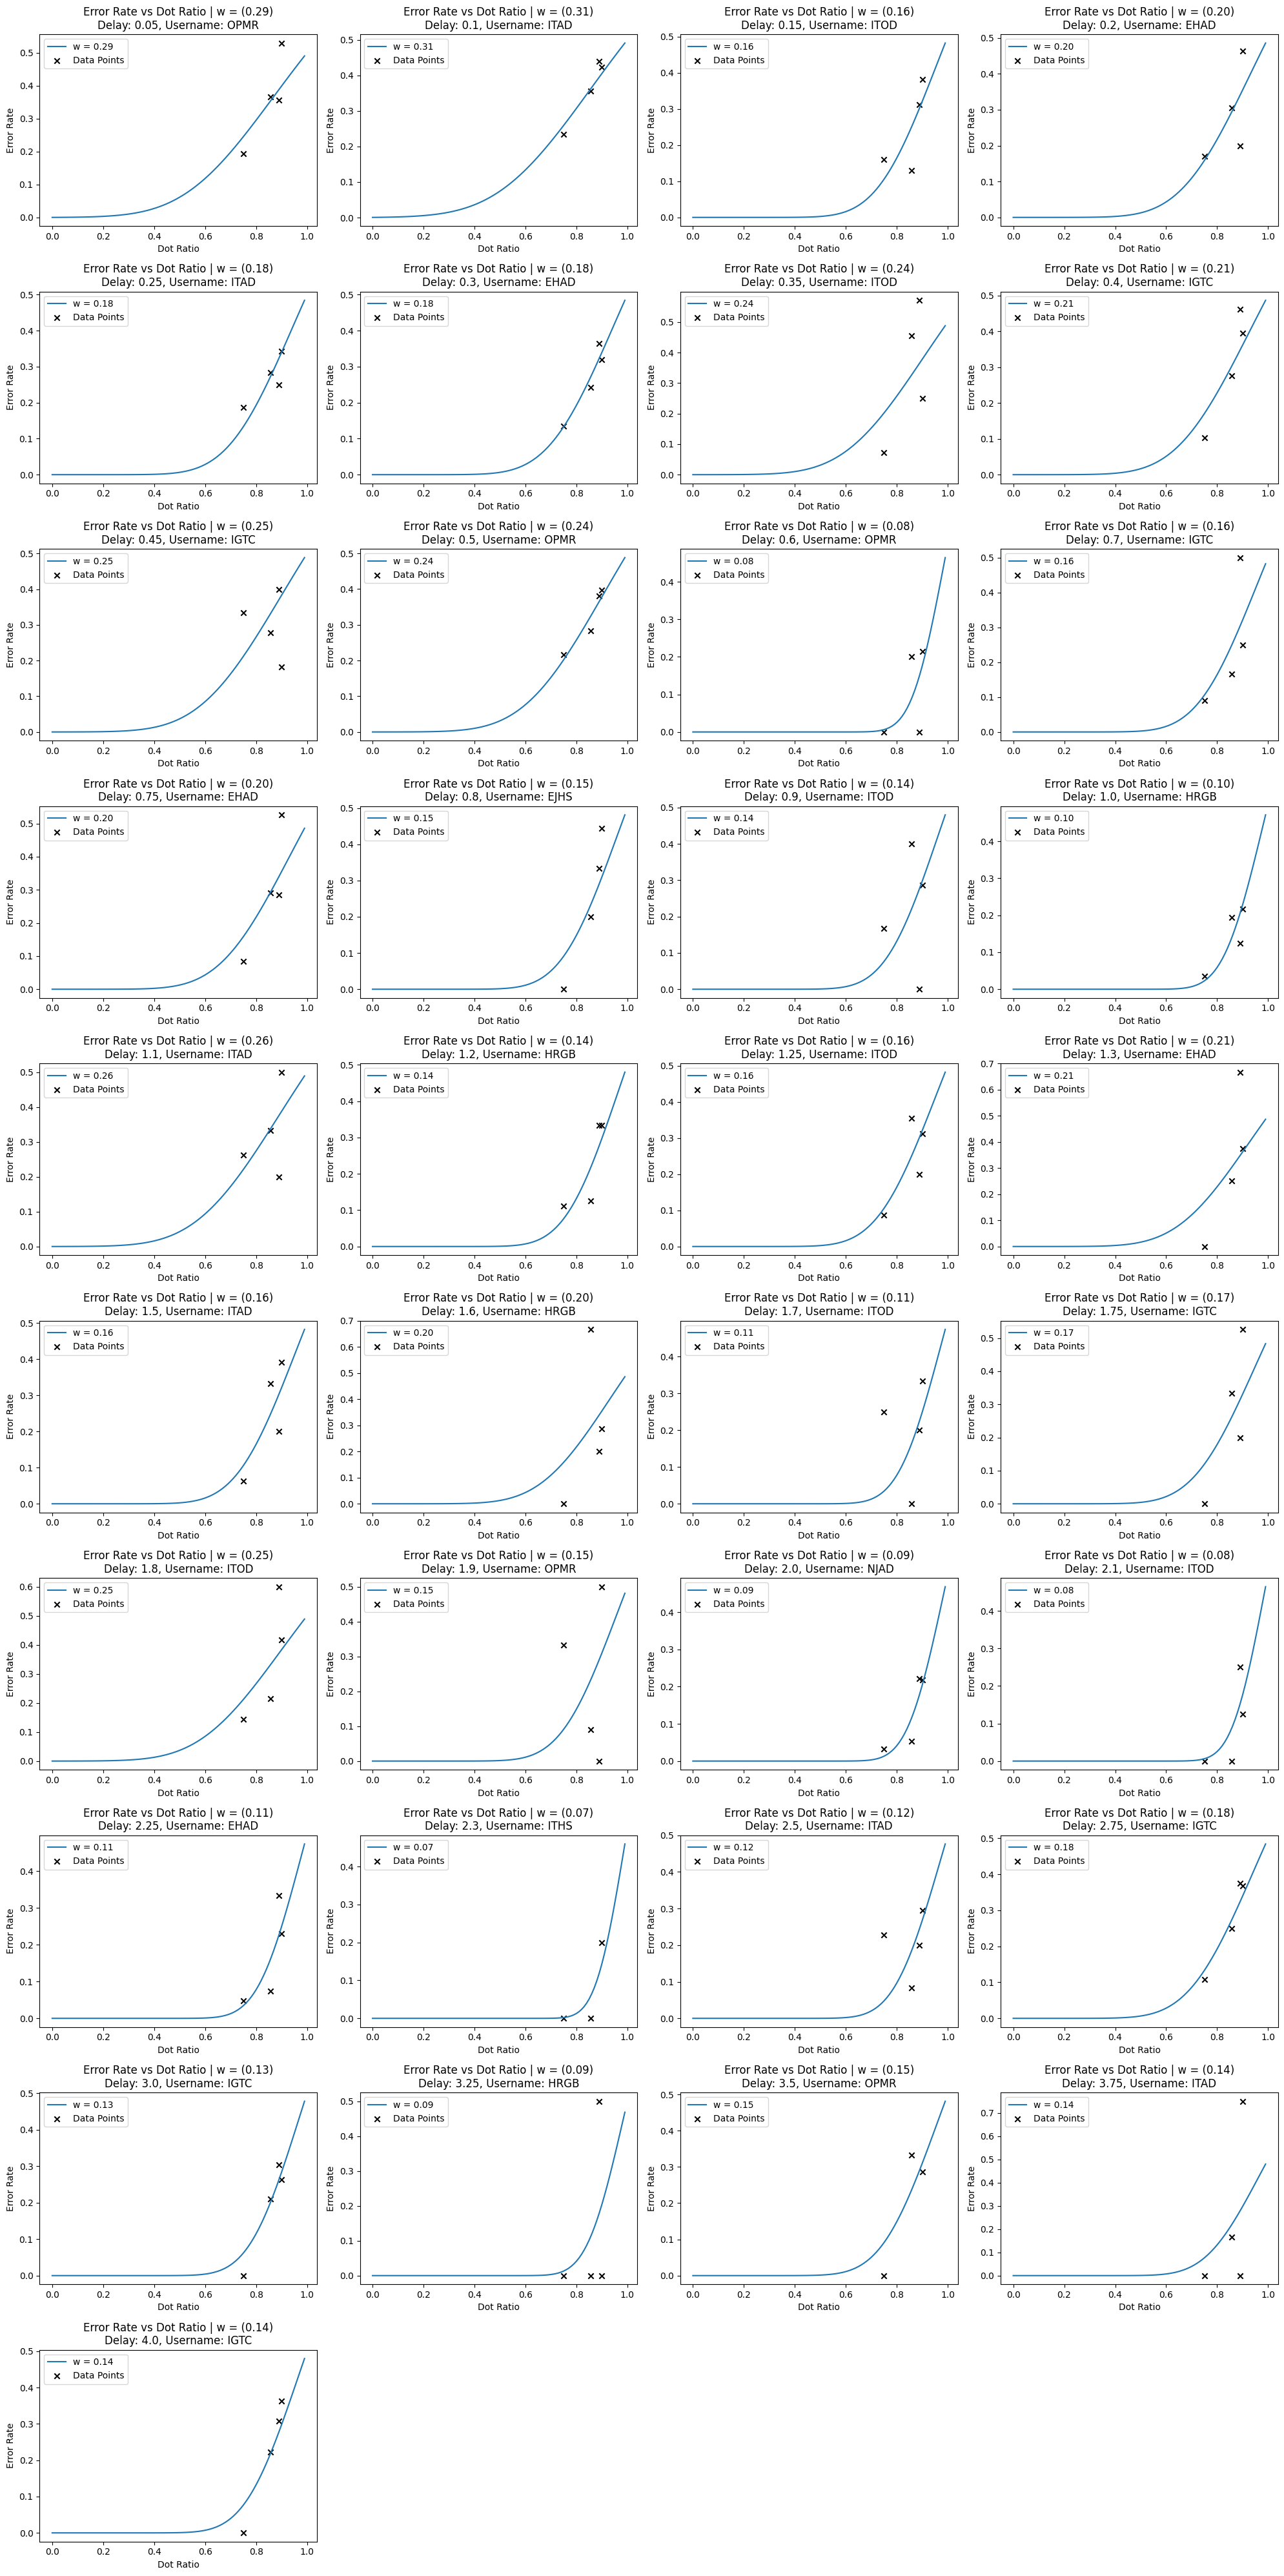

In [20]:


def plot_error_rate_graphs_in_grid(error_data, results_df):

    total_plots = len(results_df)
    columns = 4
    rows = total_plots // columns + (total_plots % columns > 0)
    
    #Create a figure to hold all subplots
    fig, axes = plt.subplots(rows, columns, figsize=(columns*5, rows*4))
    axes = axes.flatten()
    
    #Define the r_values outside the loop, as these are consistent for all plots
    r_values = np.arange(0, 1, 0.01)
    
    #Iterate through each row in results_df to get the group and its best w
    for index, (ax, row) in enumerate(zip(axes, results_df.iterrows())):
        _, row = row  
        delay = row['Delay']
        name = row['Username']
        best_w = row['Best W']
        
        #Filter the error_data for the current group
        group = error_data[(error_data['Delay'] == delay) & (error_data['Username'] == name)]
        
        #Calculate the error rate using the best w for the group
        error_list = [0.5 * math.erfc((1/best_w)*(1/math.sqrt(2))*((1-r)/math.sqrt((r**2)+1))) for r in r_values]
        
        #Plot on the current axes
        ax.plot(r_values, error_list, label=f'w = {best_w:.2f}')
        ax.scatter(group['Ratio'], group['Average Error'], marker='x', color='black', label='Data Points')
        ax.set_xlabel('Dot Ratio')
        ax.set_ylabel('Error Rate')
        ax.set_title(f'Error Rate vs Dot Ratio | w = ({best_w:.2f})\nDelay: {delay}, Username: {name}')
        ax.legend()

    #Hide any unused axes if the total plots are not a perfect multiple of columns
    for ax in axes[index+1:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#Call the modified plotting function with both DataFrames
plot_error_rate_graphs_in_grid(error_data, results_df)


In [6]:
from scipy.stats import norm
from scipy.integrate import quad
import numpy as np
import pandas as pd

mu2 = 1  #Fixed value of mu for the second distribution

def overlap_area(mu1, sigma):
    lower_bound = min(mu1, mu2) - 5 * sigma
    upper_bound = max(mu1, mu2) + 5 * sigma
    
    def integrand(x):
        return min(norm.pdf(x, mu1, sigma), norm.pdf(x, mu2, sigma))
    
    area, _ = quad(integrand, lower_bound, upper_bound)
    return area

def find_sigma(mu1, target_area, sigma_guess=1.0, tolerance=1e-4, max_iterations=1000):
    sigma_low = 0.01
    sigma_high = 1
    for _ in range(max_iterations):
        area = overlap_area(mu1, sigma_guess)
        if abs(area - target_area) < tolerance:
            return sigma_guess
        elif area > target_area:
            sigma_high = sigma_guess
        else:
            sigma_low = sigma_guess
        sigma_guess = (sigma_low + sigma_high) / 2
    return sigma_guess

def calculate_sigmas(results_df, target_area=0.5): #when target area is 0.5, then there is a half chance of being in this 50% chance so the error rate is 25%
    sigmas = []
    for W in results_df['Best W']:
        mu1 = 1 - W
        sigma = find_sigma(mu1, target_area)
        sigmas.append(sigma)
    return sigmas

#Call the calculate_sigmas function with results_df
sigmas = calculate_sigmas(results_df)

#Assign the calculated sigmas back to the DataFrame
results_df['Sigma'] = sigmas
results_df['Weber Ratio'] = 1 - results_df['Best W']

#Show the updated DataFrame
print(results_df)


    Delay Username  Best W   Min SSR     Sigma  Weber Ratio
0    0.05     OPMR    0.29  0.020778  0.214961         0.71
1    0.10     ITAD    0.31  0.003094  0.229825         0.69
2    0.15     ITOD    0.16  0.020863  0.118583         0.84
3    0.20     EHAD    0.20  0.031521  0.148252         0.80
4    0.25     ITAD    0.18  0.008114  0.133448         0.82
5    0.30     EHAD    0.18  0.003066  0.133448         0.82
6    0.35     ITOD    0.24  0.092981  0.177921         0.76
7    0.40     IGTC    0.21  0.019676  0.155684         0.79
8    0.45     IGTC    0.25  0.059145  0.185353         0.75
9    0.50     OPMR    0.24  0.002554  0.177921         0.76
10   0.60     OPMR    0.08  0.036482  0.059307         0.92
11   0.70     IGTC    0.16  0.051298  0.118583         0.84
12   0.75     EHAD    0.20  0.037839  0.148252         0.80
13   0.80     EJHS    0.15  0.029463  0.111212         0.85
14   0.90     ITOD    0.14  0.117395  0.103779         0.86
15   1.00     HRGB    0.10  0.009366  0.

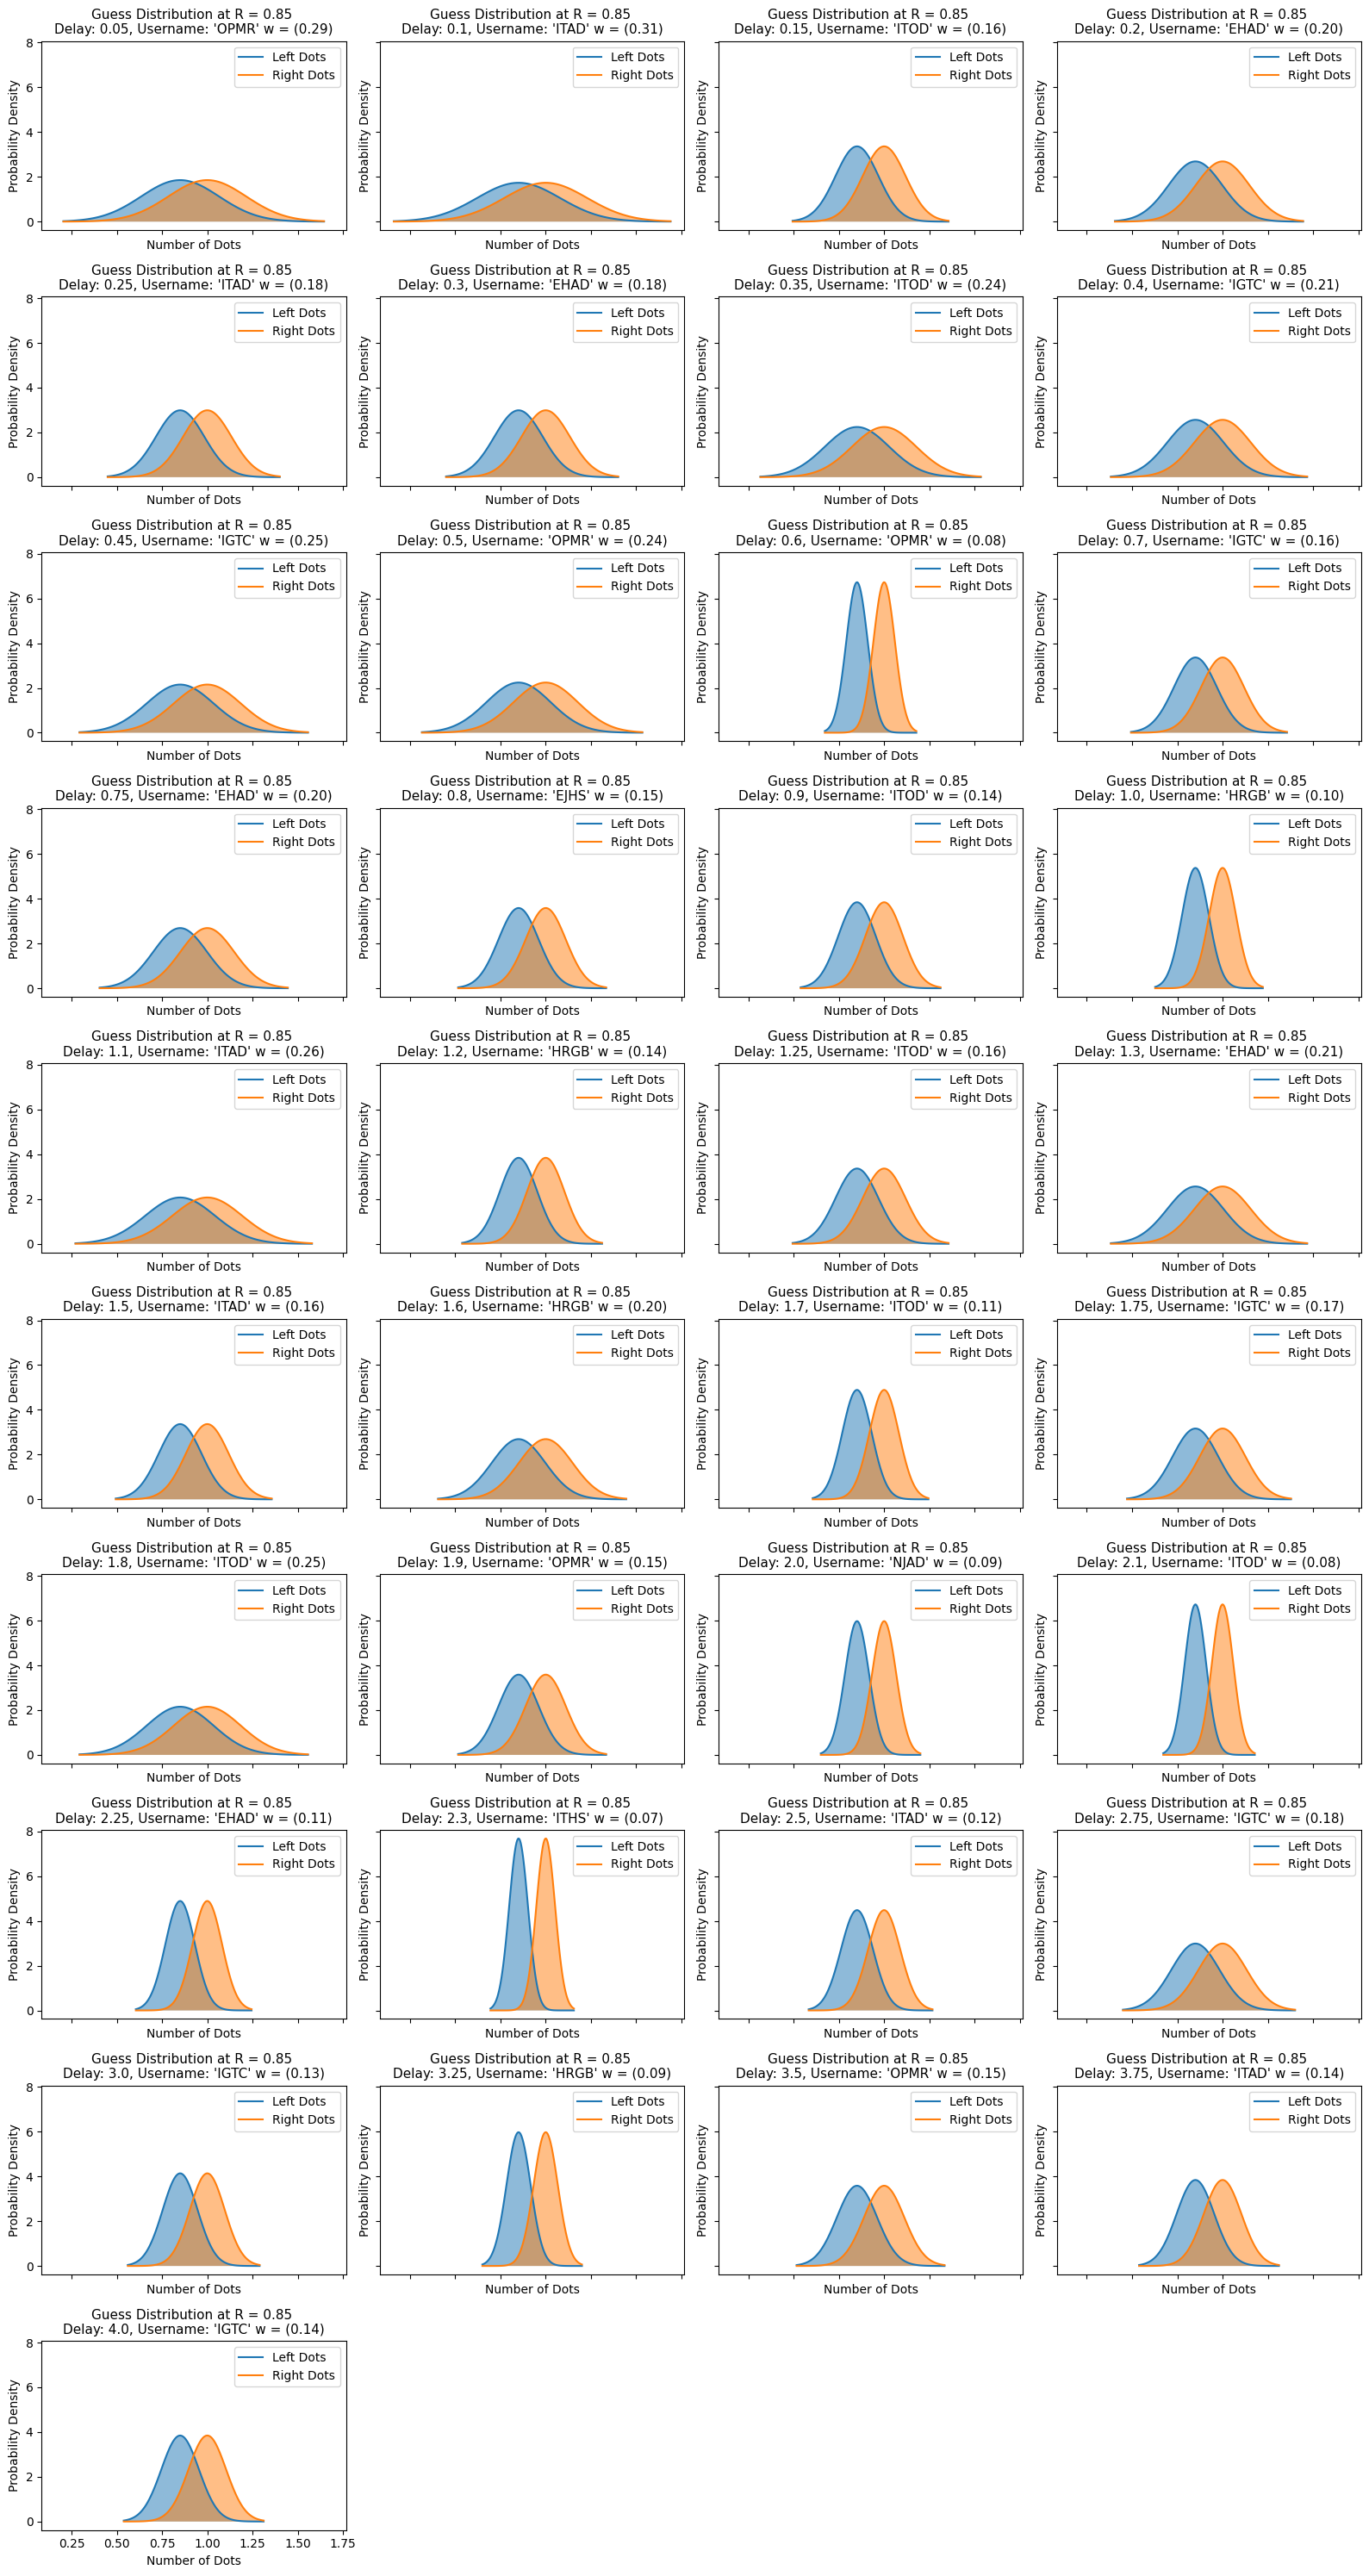

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


num_plots = len(results_df)  #Total number of plots needed
cols = 
rows = -(-num_plots // cols)  

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 3*rows), sharex=True, sharey=True)
axes = axes.flatten()  

for i, (index, row) in enumerate(results_df.iterrows()):
    mu1 = 0.85
    mu2 = 1  # mu2 is always 1
    sigma = row['Sigma']
    delay = row['Delay']
    name = row['Username']
    best_w = row['Best W']
    
    #Generate a range of x values
    x = np.linspace(mu1 - 3*sigma, mu2 + 3*sigma, 100)
    
    #Calculate the normal distribution values
    y1 = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma) ** 2)
    y2 = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma) ** 2)
    
    #Plotting the distributions on the corresponding subplot
    axes[i].plot(x, y1, label=f"Left Dots")
    axes[i].plot(x, y2, label=f"Right Dots")
    axes[i].fill_between(x, y1, alpha=0.5)
    axes[i].fill_between(x, y2, alpha=0.5)
    axes[i].legend(loc='upper right')
    axes[i].set_title(f"Guess Distribution at R = 0.85 \nDelay: {delay}, Username: '{name}' w = ({best_w:.2f})", fontsize=11)
    axes[i].set_xlabel('Number of Dots')
    axes[i].set_ylabel('Probability Density')



#Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


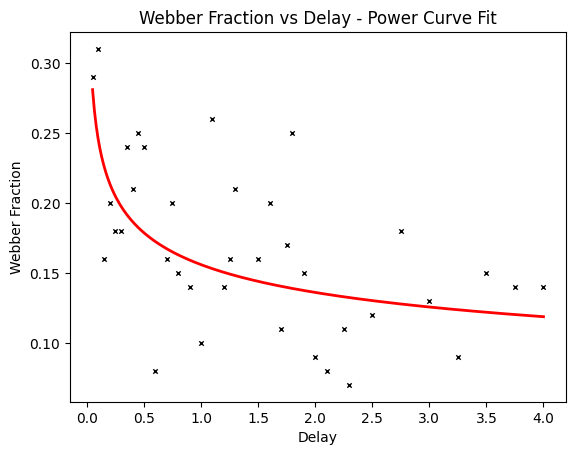

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     15.96
Date:                Sat, 17 Feb 2024   Prob (F-statistic):           0.000316
Time:                        22:40:33   Log-Likelihood:                -8.8871
No. Observations:                  37   AIC:                             21.77
Df Residuals:                      35   BIC:                             25.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8584      0.052    -35.721      0.0

/var/folders/3f/4hvscpt14tlb55w40xzyd0ph0000gn/T/ipykernel_1269/334328010.py:41: RuntimeWarning: divide by zero encountered in log
  x_log = np.log(delay_values)


,Delay,Best W,Sigma
0,0.000000,inf,1.000000
1,0.006678,0.417209,0.309224
2,0.013356,0.364084,0.269948
3,0.020033,0.336201,0.249282
4,0.026711,0.317723,0.235505
...,...,...,...
595,3.973289,0.118894,0.088129
596,3.979967,0.118855,0.088099
597,3.986644,0.118816,0.088069
598,3.993322,0.118777,0.088069


In [8]:
# This takes a while to run. The stat tests will run fast but give it time to calculate the sigmas. ~3.5 minutes 

#Function to fit a power curve and check for statistical significance
def analyze_power_curve_correlation(results_df):
    x_log = np.log(results_df['Delay'].values)
    y_log = np.log(results_df['Best W'].values)
    x_log_with_constant = sm.add_constant(x_log)
    model = sm.OLS(y_log, x_log_with_constant).fit()

    #Add a constant to the predictor variable to include the intercept in the model
    x_log_with_constant = sm.add_constant(x_log)
    
    #Fit the regression model on the transformed data
    model = sm.OLS(y_log, x_log_with_constant).fit()
    
    
    #Plotting the original data
    plt.scatter(results_df['Delay'], results_df['Best W'], marker='x', color='black', s=10, linewidth=1)
    plt.xlabel('Delay')
    plt.ylabel('Webber Fraction')
    plt.title('Webber Fraction vs Delay - Power Curve Fit')
    
    #Generating a sequence of x values for plotting the fitted curve
    x_sequence = np.linspace(min(results_df['Delay']), max(results_df['Delay']), num=250)
    
    #Predicting y values using the fitted model on the log-transformed x sequence
    y_predicted_log = model.predict(sm.add_constant(np.log(x_sequence)))
    
    #Transforming the predicted values back to the original scale using the exponential function
    y_predicted = np.exp(y_predicted_log)
    
    plt.plot(x_sequence, y_predicted, color='red', linewidth=2)  #Plot the fitted power curve
    plt.show()
    #Summary of the regression model
    print(model.summary())  #Print the summary of the regression model
    
    return model  #Return the model object for further use

def generate_continuous_values(model, delay_range=[0, 4], num_values=600):
    delay_values = np.linspace(delay_range[0], delay_range[1], num=num_values)
    x_log = np.log(delay_values)
    x_log_with_constant = sm.add_constant(x_log)
    y_predicted_log = model.predict(x_log_with_constant)
    best_w_values = np.exp(y_predicted_log)  #Convert back from log scale
    
    generated_df = pd.DataFrame({'Delay': delay_values, 'Best W': best_w_values})
    return generated_df


model = analyze_power_curve_correlation(results_df)  #Fit the model and plot the original data
generated_df = generate_continuous_values(model)  #Generate new continuous values
sigmas_generated = calculate_sigmas(generated_df)

generated_df['Sigma'] = sigmas_generated  

generated_df



In [9]:
#This just helps with visualisation of the front plane as to stop there being a large gap 
new_df = generated_df 
new_df.at[0, 'Best W'] = 0.6
new_df.at[0, 'Delay'] = 0.00001
new_df.at[0, 'Sigma'] = 0.00001
new_df



,Delay,Best W,Sigma
0,0.000010,0.600000,0.000010
1,0.006678,0.417209,0.309224
2,0.013356,0.364084,0.269948
3,0.020033,0.336201,0.249282
4,0.026711,0.317723,0.235505
...,...,...,...
595,3.973289,0.118894,0.088129
596,3.979967,0.118855,0.088099
597,3.986644,0.118816,0.088069
598,3.993322,0.118777,0.088069


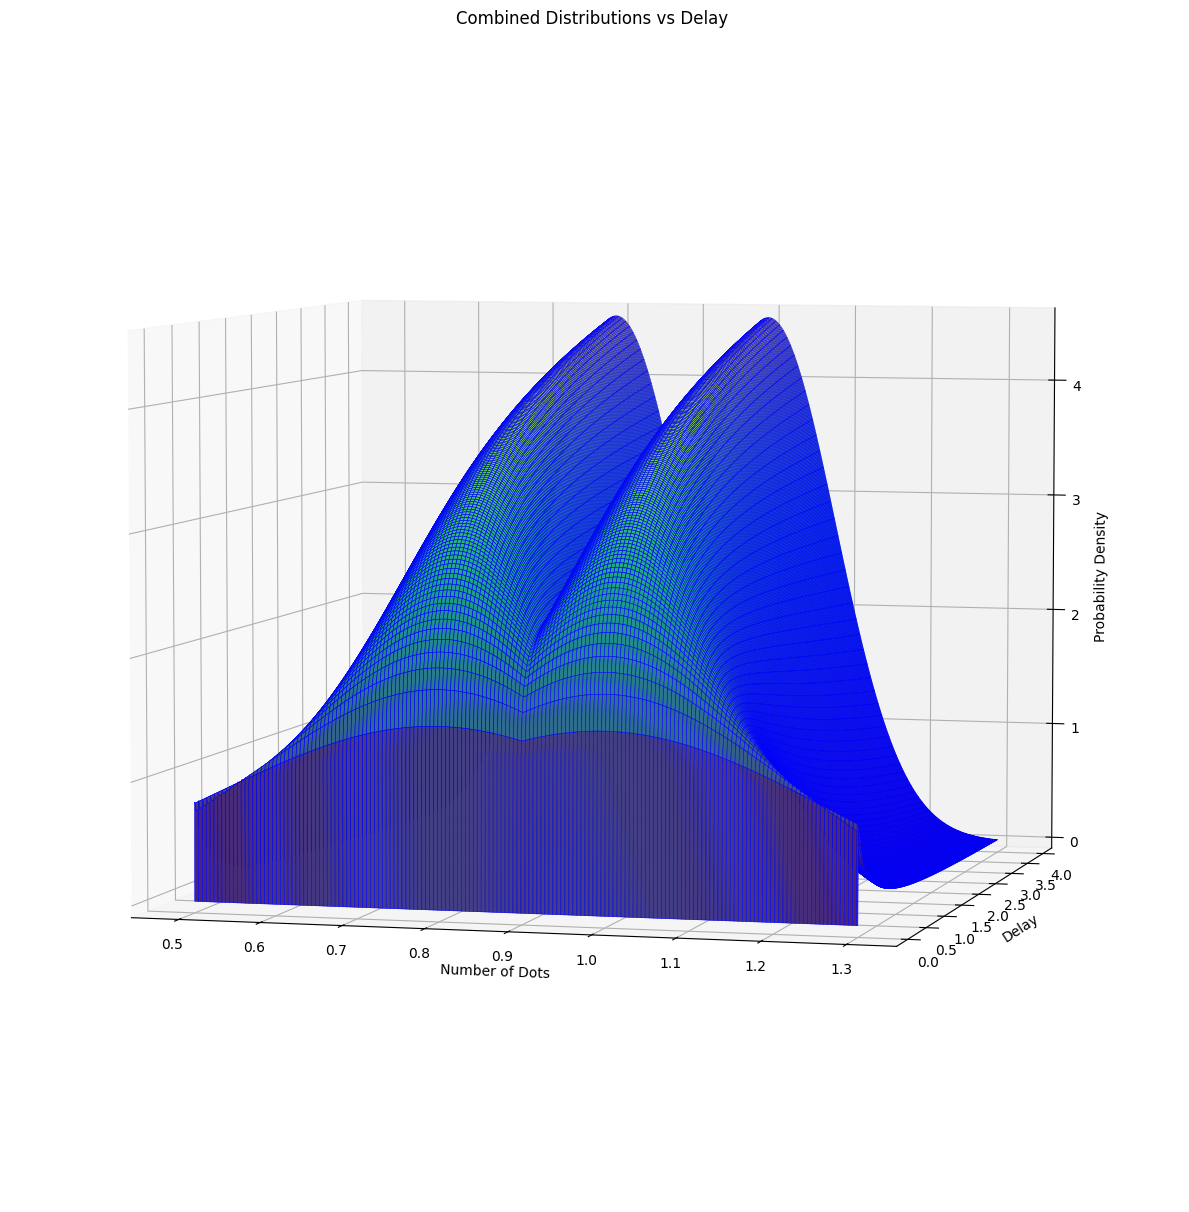

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



fig = plt.figure(figsize=(12, 40)) 

#Combined distributions plot
ax1 = fig.add_subplot(111, projection='3d')

x = np.linspace(0.50, 1.3, 500)
delays = new_df['Delay'].values
y = np.linspace(delays.max(), delays.min(), len(delays))

X, Y = np.meshgrid(x, y)

Z_mu1 = np.zeros(X.shape)
Z_mu2 = np.zeros(X.shape)

for i, delay in enumerate(y):
    idx = np.abs(new_df['Delay'] - delay).idxmin()
    best_w = new_df.iloc[idx]['Best W']
    sigma = new_df.iloc[idx]['Sigma']
    
    mu1 = 0.8
    mu2 = 1  #Fixed value again
    
    Z_mu1[i, :] = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma) ** 2)
    Z_mu2[i, :] = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma) ** 2)

#Select the maximum value at each point to create a continuous surface
Z_combined = np.maximum(Z_mu1, Z_mu2)

#Plotting the combined surface where each point takes the value of the dominant distribution
ax1.plot_surface(X, Y, Z_combined, cmap='viridis', edgecolor='blue', linewidth = 0.4, rstride=3, cstride=3, alpha = 1)
ax1.set_xlabel('Number of Dots')
ax1.set_ylabel('Delay')
ax1.set_zlabel('Probability Density')
ax1.set_title('Combined Distributions vs Delay ')
ax1.view_init(elev=5, azim=-75)  

plt.tight_layout()
plt.show()



In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display


def plot_3d(ratio=0.77):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    x = np.linspace(0.3, 1.47, 100)
    delays = new_df['Delay'].values
    y = np.linspace(delays.min(), delays.max(), len(delays))

    X, Y = np.meshgrid(x, y)

    Z_mu1 = np.zeros(X.shape) 
    Z_mu2 = np.zeros(X.shape) 

    for i, delay in enumerate(y):
        idx = np.abs(new_df['Delay'] - delay).idxmin()
        best_w = new_df.iloc[idx]['Best W']
        sigma = new_df.iloc[idx]['Sigma']
        
        #This calculates a new values for mu1 and mu2 from the new ration, but ensures they shift by the same amount
        mu1 = 0.77 - ((0.77- ratio)/(ratio+1))
        mu2 = 1 + ((0.77- ratio)/(ratio+1))
        
        Z_mu1[i, :] = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma) ** 2)
        Z_mu2[i, :] = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma) ** 2)

    Z_combined = np.maximum(Z_mu1, Z_mu2)

    ax.plot_surface(X, Y, Z_combined, cmap='viridis', edgecolor='blue', linewidth = 0.2, rstride=4, cstride=4, alpha = 1)
    ax.set_xlabel('Number of Dots')
    ax.set_ylabel('Delay')
    ax.set_zlabel('Probability Density')
    ax.set_title('Combined Distributions vs Delay (Seamless Transition)')
    ax.view_init(elev=5, azim=-75)
    
    plt.show()


ratio_slider = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.77, description='Dot Ratio')

#Display the interactive plot
widgets.interactive(plot_3d, ratio=ratio_slider)









interactive(children=(FloatSlider(value=0.77, description='Dot Ratio', max=1.0, step=0.01), Output()), _dom_cl…

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.integrate import simps  
from ipywidgets import widgets, Layout



def plot_3d(ratio=0.77, delay=0.5):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    x = np.linspace(0.3, 1.47, 100)
    delays = new_df['Delay'].values
    y = np.linspace(delays.min(), delays.max(), len(delays))

    X, Y = np.meshgrid(x, y)

    Z_mu1 = np.zeros(X.shape) 
    Z_mu2 = np.zeros(X.shape)

    for i, d in enumerate(y):
        idx = np.abs(new_df['Delay'] - d).idxmin()
        best_w = new_df.iloc[idx]['Best W']
        sigma = new_df.iloc[idx]['Sigma']
        
        mu1 = 0.77 - ((0.77- ratio)/(ratio+1)) #This calculates new values for new ratio but shifts them by the same amount 
        mu2 = 1 + ((0.77- ratio)/(ratio+1))
        
        Z_mu1[i, :] = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma) ** 2)
        Z_mu2[i, :] = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma) ** 2)

    Z_combined = np.maximum(Z_mu1, Z_mu2)

    ax.plot_surface(X, Y, Z_combined, color='turquoise', edgecolor='none', rstride=6, cstride=6, alpha=0.4)
    ax.set_xlabel('Number of Dots')
    ax.set_ylabel('Delay')
    ax.set_zlabel('Probability Density')
    ax.set_title('Model Fitted Guess Distributions vs Delay', pad=0.1)
    ax.view_init(elev=5, azim=-75)


    #Find the specific delay index and values for mu1 and mu2 at that delay
    delay_idx = np.abs(y - delay).argmin()
    Z_mu1_delay = Z_mu1[delay_idx, :]
    Z_mu2_delay = Z_mu2[delay_idx, :]
    Z_combined_delay = np.maximum(Z_mu1_delay, Z_mu2_delay)
    Z_intersection_delay = np.minimum(Z_mu1_delay, Z_mu2_delay)

    # Calculate the area under the intersection curve at the specific delay
    # Essentially gives the area under the overlapping refion
    # When there is full overlap the total area = 1
    # But you have a 50% chance of guessing the correct side whatever the scenario. It's like what is the chance of error within that
    # free 50% we were given, but now we're trying to find it for the 100%. So we divide by 2. 
    #its the chance of being in the overlap but if youre in the overlap youve still got a 50% chance of getting it right so its half the overlap 
    area = simps(Z_intersection_delay, x)
    print(f"Predicted chance of error at delay {delay:.2f} seconds and ratio {ratio}: {(area*100)/2:.4f}%")

    #Plot the outlines for mu1 and mu2 at the specific delay
    ax.plot(x, [delay] * len(x), Z_mu1_delay, color='r', linewidth=2, label='Left Dots Guess Distribution')
    ax.plot(x, [delay] * len(x), Z_mu2_delay, color='b', linewidth=2, label='Right Dots Guess Distribution')
    

    #Reintegrate the vertical lines for the 2D intersection plot
    for i, val in enumerate(x):
        ax.plot([val, val], [delay, delay], [0, Z_intersection_delay[i]], color='black', linewidth=2)

    plt.legend(loc='upper right')
 
    plt.show()

ratio_slider = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.77, description='Dot Ratio')
delay_slider = widgets.FloatSlider(min=new_df['Delay'].min(), max=new_df['Delay'].max(), step=0.01, value=0.5, description='Delay')

#Display the interactive plot with both sliders
interactive_plot = widgets.interactive(plot_3d, ratio=ratio_slider, delay=delay_slider)
output = interactive_plot.children[-1]
output.layout.height = '800px'
display(interactive_plot)


interactive(children=(FloatSlider(value=0.77, description='Dot Ratio', max=1.0, step=0.01), FloatSlider(value=…